# Multiclass classification

**Before this notebook, you should look at [Pandas_for_ML_data_management.ipynb](Pandas_for_ML_data_management.ipynb).**

## The machine learning iterative loop

![Iterative loop](../images/ML_loop.png)

## The lithology prediction task

<img src="../images/machine_learning_primer.png"></img>

## Load the data

In [1]:
import pandas as pd

df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/Panoma_training_data.csv')
df.head()

,Well Name,Depth,Formation,RelPos,Marine,GR,ILD,DeltaPHI,PHIND,PE,Facies,LATITUDE,LONGITUDE,ILD_log10,Lithology,RHOB,Mineralogy,Siliciclastic
0,SHRIMPLIN,851.3064,A1 SH,1.000,1,77.45,4.613176,9.9,11.915,4.6,3.0,37.978076,-100.987305,0.664,siltstone,2393.499945,siliciclastic,True
1,SHRIMPLIN,851.4588,A1 SH,0.979,1,78.26,4.581419,14.2,12.565,4.1,3.0,37.978076,-100.987305,0.661,siltstone,2416.119814,siliciclastic,True
2,SHRIMPLIN,851.6112,A1 SH,0.957,1,79.05,4.549881,14.8,13.050,3.6,3.0,37.978076,-100.987305,0.658,siltstone,2404.576056,siliciclastic,True
3,SHRIMPLIN,851.7636,A1 SH,0.936,1,86.10,4.518559,13.9,13.115,3.5,3.0,37.978076,-100.987305,0.655,siltstone,2393.249071,siliciclastic,True
4,SHRIMPLIN,851.9160,A1 SH,0.915,1,74.58,4.436086,13.5,13.300,3.4,3.0,37.978076,-100.987305,0.647,siltstone,2382.602601,siliciclastic,True


## Make `X` and `y`

### EXERCISE

**Make the `X` and `y` arrays we'll use for training.** `X` is going to be the columns `'GR','RHOB','PE','ILD_log10'` and `y` will be the `'Lithology'` column. Cast the data to NumPy arrays. <a title="Use ordinary dict-style indexing to get the columns out of the DataFrame. Use the values attribute of the columns to get the equivalent NumPy array."><b>Hover for HINT</b></a>

In [2]:
# YOUR CODE HERE
features = [...]
X = 
y = 

SyntaxError: invalid syntax (18259793.py, line 3)

In [2]:
features = ['GR','RHOB','PE','ILD_log10']

# You *can* leave these as Pandas objects, but I prefer NumPy arrays, especially for plotting.
X = df[features].values
y = df['Lithology'].values

In [5]:
N, M = X.shape
assert N >= 3900, "There should be more records"
assert M == 4, "There should be 4 features"
assert y.size == N, "The length of y should match X"

## Split the data

In general, you need three datasets for training and evaulating models:

- **Train** &mdash; For fitting a candidate model.
- **Val** &mdash; For seeing how well a candidate model generalizes.
- **Test** &mdash; For seeing how well the final model generalizes.

Be careful; people give these different names sometimes.

There are two general approaches to validation:

![Validation strategies](../images/validation_strategies.png)

We'll only keep three fully separate datasets if we can afford the data. Often we don't have as much data as we'd like and it's advantageous to combine **train** and **val** into a single dataset. Many people refer to this as 'cross validation' (though note that this can refer to the hold-out strategy as well).

There are a few ways we could do this:

- Randomly split the _records_ into **train**, **val** and **test** sets.
- Split up _formations_ (or beds, or ages) into **train**, **val** and **test** sets.
- Split up the _wells_ into **train**, **val** and **test** sets.
- Split up _groups of wells_ into **train**, **val** and **test** sets.

**❓ Which approach should we use?**

## The IID assumption

**IID** stands for **independent and identically distributed**, and most machine learning algorithms implicitly assume your data are IID.

Let's look at I and ID in turn:

### Independent

Our data records are not strictly independent and identically distributed. So splitting like this is not a great idea for these data. We should split by well instead.

[No-one is immune to this kind of error!](https://twitter.com/andrewyng/status/931026446717296640)


### Identically distributed

Think of the classes in the data: sandstone, limestone, etc. There are not equal numbers of each lithology. When splitting the dataset, we need to ensure that we maintain the distribution **with respect to the labels**. 

Now think of the features: GR, RHOB, etc. These vary widely across the dataset. Clearly it would be bad to end up with all the high-GR samples in `train` with none in `val`: we would never validate those samples. So we also need to maintain the distribution of the data **with respect to the features**. 

The distributions don't really need to be totally identical, that would be impossible. But they should be very alike.

### EXERCISE

What is the distribution of lithologies across the entire dataset? You can make a small table, or a plot. <a title="Check out the value_counts() method on the dataframe"><b>Hover for HINT</b></a>

What is the distribution of lithologies across the wells? <a title="Check out pd.crosstab"><b>Hover for HINT</b></a>

In [9]:
# YOUR CODE HERE


<AxesSubplot:>

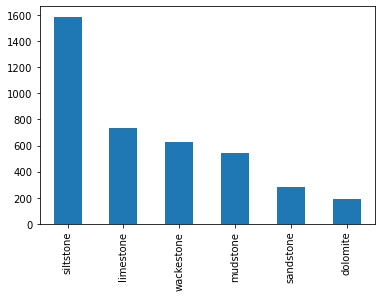

In [6]:
# Build this up.
df['Lithology'].value_counts().plot(kind='bar')

In [7]:
pd.crosstab(df['Lithology'], df['Well Name'])

Well Name,CHURCHMAN BIBLE,CRAWFORD,CROSS H CATTLE,LUKE G U,NEWBY,NOLAN,SHANKLE,SHRIMPLIN,STUART
Lithology,,,,,,,,,
dolomite,34,63,2,20,16,4,17,5,29
limestone,125,75,68,74,87,116,40,81,71
mudstone,43,55,53,37,86,75,26,81,87
sandstone,8,15,158,0,0,4,89,0,8
siltstone,106,77,184,246,178,186,205,241,163
wackestone,87,62,31,84,96,30,71,63,104


### Let's split!

We're going to use a cross-validation strategy for the training wells, and only split out a test set.

But if you have enough training data, it's probably better to stick to holdout sets.

In [62]:
train_wells = ['CHURCHMAN BIBLE', 'CROSS H CATTLE', 'LUKE G U', 'NEWBY', 'NOLAN', 'SHANKLE', 'SHRIMPLIN']

train_flag = df['Well Name'].isin(train_wells)
train_flag

0        True
1        True
2        True
3        True
4        True
        ...  
3961    False
3962    False
3963    False
3964    False
3965    False
Name: Well Name, Length: 3966, dtype: bool

Now we can use this flag to pull out wells:

In [63]:
X_train = df.loc[train_flag, features].values
y_train = df.loc[train_flag, 'Lithology'].values

# And we might need this later...
wells = df.loc[train_flag, 'Well Name'].values

In [64]:
X_train.shape, y_train.shape

((3157, 4), (3157,))

And for test:

In [65]:
X_test = df.loc[~train_flag, features].values
y_test = df.loc[~train_flag, 'Lithology'].values

In [66]:
X_test.shape, y_test.shape

((809, 4), (809,))

## Sanity check the distributions

Let's visualize the distributions over the features, for each of the datasets. We'd like the distributions to match, i.e. training matches val and test.

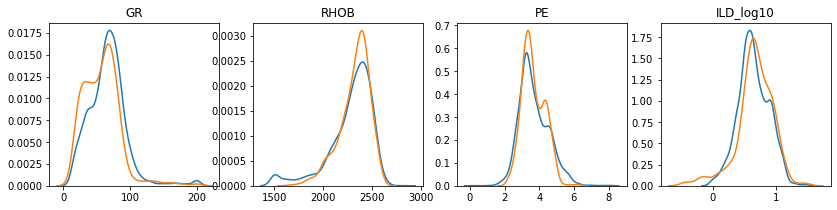

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=4, figsize=(14,3))

for ax, feature, *datasets in zip(axs, features, X_train.T, X_test.T):
    for dataset in datasets:
        sns.kdeplot(dataset, ax=ax)
    ax.set_ylabel(None)
    ax.set_title(feature)

In the data space, two of the parameters look like this:

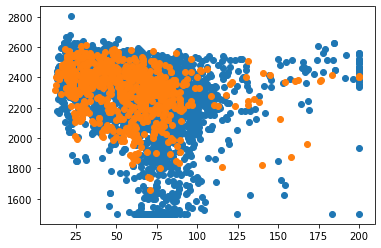

In [68]:
plt.scatter(X_train[:,0], X_train[:,1])
plt.scatter(X_test[:,0], X_test[:,1])

## Scale the data

Some methods don't care about the scale of the features. For example, decision trees and random forests treat each feature independently.

However, most methods &mdash; for example those relying on distance (e.g. KNN), or on linear combinations (e.g. linear regression), or on squeezing functions (e.g. neural nets) &mdash; require the data to be normalized or standardized:

- **Normalization**: scaling to a range of [0, 1] or [-1, +1] for example. As a rule of thumb, you might do this for uniformly distributed data.
- **Standardization**: scaling to a zero mean and unit variance (also known as Z-score). Do this for normally (Gaussian) distributed data.

It's likely a good idea to scale it no matter which method you try.

`scikit-learn` has lots of scalers. The `StandardScaler` removes the mean and scales the data to unit variance.

We fit a scaler to the training data, then transform all the datasets, with a pattern that will become very familiar:

In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_scaled = scaler.transform(X_train)

**Note that we're not actually going to scale the data at this point. We just want to see what the scaled data will look like.**

Now let's plot the data using equal axes:

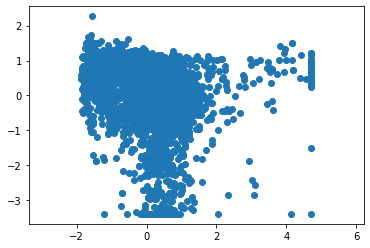

In [70]:
plt.scatter(X_scaled[:,0], X_scaled[:,1])
plt.axis('equal')
plt.show()

This is better. A few things to note about scaling:

### Fit the scaler to `train`

One of our goals in machine learning is to create fair, unbiased models. The validation and test sets are how we judge fairness and bias. It's very important that information does not **leak** from these datasets into the training process. 

For this reason, it's imperative to fit the scaler (i.e. for the standardizer, to set the mean and standard deviation) on the **training** data only. It must not 'know' about the mean or range of the data you'll use to evaluate the model. 

This tells you why it's so important to ensure that the datsasets are 'identically distributed'.

### It's not magic

Data normalization doesn't magically fix problems with the data. If you're lumping a bunch of well data together and the GR, say, is calibrated differently in each well, or the RHOB units vary, then the scaled data will also have this problem. So you still need to QC your data to ensure it's internally consistent.

### Should you scale the target?

There is usually no advantage to scaling the target, and it does make model evaluation a bit more fiddly, so we generally don't do it.

The exception is for some neural network approaches. Very large magnitudes may result in 'exploding gradients', which in turn may result in 'saturation' (for some activation functions), or in very large updates to the parameters. Either way, the network will struggle to learn. So in these cases, we will sometimes scale a regression target for a neural network.

---

## A simple model: _k_-NN

In [71]:
import sklearn

print(sklearn.__version__)

# Make sure we can see all of the model details.
sklearn.set_config(print_changed_only=False)

0.24.2


A fairly naive, **non-parametric** method for classifying data is the _k-nearest neighbours_ algorithm. 'Non-parametric' means that, strictly speaking, it's not quite machine learning: no parameters are being learned during training. The algorithm simply remembers all the data and uses it to do spatial queries for new data points.

The label of the object in question is determined by the neighbouring data points in the feature space used. Its most important parameter, *k*, called `n_neighbors` in the `sklearn` library, is the number of neighbours you include to make a prediction.

Now we're ready to do some machine learning. First we import, then instantiate, the classifier:

In [72]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(),
                      KNeighborsClassifier(),
                     )

### `fit` (train)

The next block is all you need to train a classifier model!

In [73]:
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

But training this way doesn't give us a way to validate. We need to use cross-validation.

That works in a slightly different way: `sklearn` is going to do the fitting:

In [74]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train)
scores

array([0.606, 0.559, 0.596, 0.58 , 0.575])

Notice that there are five scores, because the default cross-validation happens across 5 random splits. These are stratified (they take the classes into account), but they are not in line with our wells.

In [75]:
import numpy as np

np.unique(wells)

array(['CHURCHMAN BIBLE', 'CROSS H CATTLE', 'LUKE G U', 'NEWBY', 'NOLAN',
       'SHANKLE', 'SHRIMPLIN'], dtype=object)

In [76]:
from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()

scores = cross_val_score(model, X_train, y_train, cv=logo, groups=wells, n_jobs=6)
scores

array([0.514, 0.454, 0.607, 0.564, 0.578, 0.542, 0.641])

Remember the deistribtion of facies in the well?

Why is the Cross H Cattle score so bad?

### `predict`

In [77]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(model, X_train, y_train, cv=logo, groups=wells, n_jobs=6)

In [78]:
y_pred == y_train

# Then: sum(y_pred == y_train) / y_train.size

array([False, False,  True, ..., False,  True, False])

In [79]:
for pair in zip(y_pred, y_train):
    print(pair)

('limestone', 'siltstone')
('wackestone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('sandstone', 'siltstone')
('sandstone', 'siltstone')
('sandstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('sandstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('sandstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('siltstone', 'siltstone')
('sandstone', 'siltstone')
('dolomite', 'siltstone')
('wackestone', 'siltstone')
('siltstone', 'siltstone')


Another approach might involve plotting, and often we'd like integers anyway. 

We could use the `LabelEncoder` in sklearn, but I want to control the order, so let's do this:

In [80]:
import numpy as np

def label_encode(array, classes):
    return np.array(list(map(list(classes).index, array)))

classes = {
    'sandstone': '#F4D03F',
    'siltstone': '#F3E8BF' ,
    'mudstone': '#C1C1C1',
    'wackestone': '#728393',
    'limestone': '#2E86C1',
    'dolomite': '#C186C1'
}

print(label_encode(classes, classes.keys()))

y_train_int = label_encode(y_train, classes.keys())
y_pred_int = label_encode(y_pred, classes.keys())

[0 1 2 3 4 5]


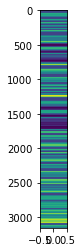

In [81]:
plt.imshow(y_train_int.reshape(-1, 1), aspect=0.0025)

/tmp/ipykernel_119669/264651316.py:17: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(im, ticks=[0, 1, 2, 3, 4, 5])


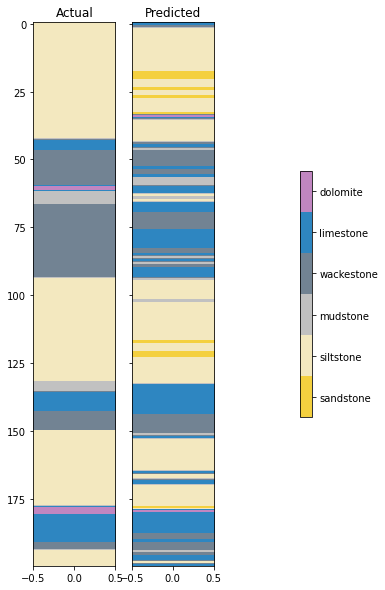

In [82]:
from matplotlib.colors import ListedColormap
import matplotlib.ticker as plticker

fig, axs = plt.subplots(ncols=2, figsize=(5, 10), sharey=True)

cmap_facies = ListedColormap(classes.values(), 'indexed')

ax = axs[0]
im = ax.imshow(y_train_int[:300].reshape(-1, 1), aspect='auto', cmap=cmap_facies, vmin=-0.5, vmax=5.5)
ax.set_title('Actual')
ax.xaxis.set_visible(False)
loc = plticker.MultipleLocator(base=25.0)
ax.yaxis.set_major_locator(loc)
loc = plticker.MultipleLocator(base=5.0)
ax.yaxis.set_minor_locator(loc)

ax = axs[1]
im = ax.imshow(y_pred_int[:300].reshape(-1, 1), aspect='auto', cmap=cmap_facies, vmin=-0.5, vmax=5.5)
ax.set_title('Predicted')
ax.xaxis.set_visible(False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.05, 0.5])
cbar = fig.colorbar(im, ticks=[0, 1, 2, 3, 4, 5], cax=cbar_ax)
cbar.ax.set_yticklabels(classes.keys())

plt.show()

You might see `model.score()` in tutorials or the `sklearn` docs. But note that when using cross-validation `model.score()` can only tell you how you do on a single dataset, like `X_train` or `X_test`. In our case, we don't have a validation set we can do intermediate validation on &mdash; because we're using cross-validation.

In [83]:
score = model.score(X_train, y_train)
print(f"The training accuracy is {score*100:.1f}%")

The training accuracy is 80.3%


It's better to choose a scoring metric deliberately. For classification problems, the weighted F1 score is a good bet:

In [84]:
scores = cross_val_score(model, X_train, y_train, scoring='f1_weighted', cv=logo, groups=wells, n_jobs=6)
scores

array([0.497, 0.386, 0.619, 0.548, 0.616, 0.517, 0.647])

## Accuracy is (usually) not enough

The _accuracy_ is just one of the _metrics_ we can use to check the quality of the predictions. There are a large number of different metrics and depending on your data and problem you may need to find the one that adjusts better to your needs.

In a binary classification with balanced classes, the accuracy score is useful. But... in general accuracy can be misleading, especially in datasets with unbalanced classes. A more robust metric is the `F1` metric. It combines the `precision` score and `recall` for each class:

$$ \mathrm{F1} = \frac{2}{\frac{1}{\mathrm{precision}}+ \frac{1}{\mathrm{recall}}} $$

Scikit-learn gives a nice summary of these three metrics using `classification_report`.

In [85]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred, digits=3, ))

              precision    recall  f1-score   support

    dolomite      0.237     0.184     0.207        98
   limestone      0.564     0.584     0.574       591
    mudstone      0.302     0.264     0.282       401
   sandstone      0.172     0.104     0.130       259
   siltstone      0.716     0.828     0.768      1346
  wackestone      0.365     0.318     0.340       462

    accuracy                          0.557      3157
   macro avg      0.392     0.380     0.383      3157
weighted avg      0.524     0.557     0.537      3157



We can also use `cross_validation()` to get at any set of scores, including the training score. We'll do this shortly.

#### What on earth is macro average?

From [this nice answer](https://datascience.stackexchange.com/a/24051/70391) on SO:

>  A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average [`sklearn` calls it the weighted average] will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average [weighted average] is preferable if you suspect there might be class imbalance.

Since we almost always have imbalanced classes, we should usually prefer the weighted average.

## Dealing with class imbalance

"Class imbalance" means that we have more of some labels than others. This does lead to problems in both training and evaluation.

- Collect more data, if it's an option.
- Choose correct evaluation metrics (some attempt to handle imbalance, eg F1 vs accuracy).
- Choose models that handle imbalance well, e.g. tree-based models. (Some implementations, like XGBoost, try to implicitly handle imbalance.)
- When splitting into holdout or cross-validation datasets, use _stratified_ variants. Note that this is the default behaviour in Scikit-Learn's cross-validation functions, but _not_ in `train_test_split()`.
- If the problem is an over-abundant class, split that class into groups, and mix with the rare class (which you repeat in each group).
- If the problem is an over-abundant class, under-sample the abundant class(es) -- but this means losing the learning effect from those samples.
- If the problem is an over-abundant class, cluster the abundant class into _r_ clusters (where _r_ is the number of instances in the rare class). In other words, you're sort of undersampling without losing the information.
- If the problem is an _under_-abundant class, over-sample that rare class, e.g. by repeating or fuzzing (adding some random noise in each dimension).
- Simulate synthetic samples for the rare class (e.g. with SMOTE).
- Use a custom cost function, or a cost matrix, that penalizes errors on the rare class(es).

I found this library, which could be useful if you're considering over- or under-sampling as a strategy: https://github.com/scikit-learn-contrib/imbalanced-learn

## Confusion matrix

The [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is another option: which classes are being confused with which?  Scikit-learn has a function for that!

In [86]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_pred)

array([[  18,   26,   14,    5,   31,    4],
       [  26,  345,   58,    2,   54,  106],
       [   7,   62,  106,   14,   93,  119],
       [   1,    1,    6,   27,  223,    1],
       [  16,   35,   50,  104, 1115,   26],
       [   8,  143,  117,    5,   42,  147]])

But as you can see, it's not very clear... What does each row/column represent? There's another function that's a bit more informative, `sklearn.metrics.plot_confusion_matrix()` but it doesn't quite work with cross validation pipelines. So we made one that does:

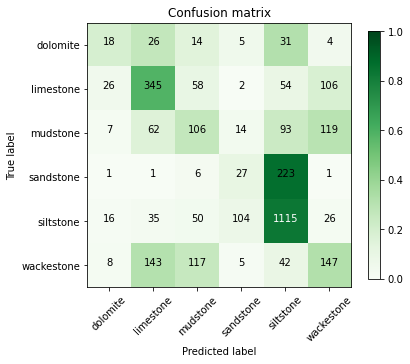

In [87]:
import mlutils

mlutils.plot_confusion_matrix(y_train, y_pred)

### Precision-recall, sensitivity-specificity, etc.

**Accuracy** is simply the number of correct predictions divided by the total number of predictions. The number and types of error don't come into it. There's one number for the entire prediction. And it omits a big part of the story.

There are various ways to capture the kinds of errors the classifier makes. Confusingly, they all have synonyms too (shown here)...

- **Precision, or positive predictive value**: of the instances predicted as class Ⓐ, what proportion were correct?
- **Recall, sensitivity, hit rate, or true positive rate**: what proportion of all Ⓐ instances were correctly predicted as Ⓐ?
- **Specificity, selectivity, or true negative rate ( = 1 - false positive rate)**: what proportion of all non-Ⓐ instances were correctly predicted as non-Ⓐ?

We tend to consider either precision and recall, or sensitivity (the same as recall) and specificity. There's a trade-off between the two: better recall involves giving up some precision and vice-versa.

The ROC curve tries to capture this trade-off. Look for [the binary classification notebook](Binary_classification.ipynb).

## Subtlety in the score

Let's look at two types of error. 

Both of these are errors in the eyes of the ML algorithm, but not necessarily in the eyes of the geologist.

First: predicting 8 (maybe coarse sand) instead of 7 (fine sand) should not be as bad as predicting 2 (say, basalt) instead of 7. How could we fix this?

<img src="../images/classification_errors.png" />

## The baseline: a dummy classifier

The dummy classifier tries to answer the question, "How well can I do with zero intelligence?". In other words, given the relative proportions of facies, what would you expect from random weighted guesses?

In [88]:
from sklearn.dummy import DummyClassifier

clf = make_pipeline(StandardScaler(), DummyClassifier())

scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=logo, groups=wells, n_jobs=6)
scores

array([0.11 , 0.201, 0.371, 0.214, 0.277, 0.287, 0.346])

In essence, if I can't beat the dummy model, then my model is definitely not useful.

Another measure of 'useful' is whether the classifier can beat a human (but don't forget that these labels were generated by a human!).

## Improving the performance

Depending on you requirements, this results might be good enough to deploy this model and use it in production but it is usually not the best model you can get. Each method has a set of controls or arguments, known as _hyperparameters_, that can be tweaked to tune the training.

Note that we don't call these settings 'parameters' because that word is reserved for the learnable parameters, weights, or coefficients in the model (e.g. $\mathbf{w}$ and $b$ in $\hat{y} = \mathbf{w}\mathbf{x} + b$).

For the `KNeighborsClassifier` there are a few of these hyperparameters:

In [89]:
KNeighborsClassifier()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

For this particular method, the most important hyperparameter to adjust is `n_neighbors` (it's the `k` in the `KNeighborsClassifier`). Unfortunately, there's no rule that tells you what's the optimal value of `k`. To overcome this we can train many models with different values of `k` and compare the results of classifications applied to the _Validation_ data.

Loop over each value in `k` and store the F1 score for each attempt:

Text(0, 0.5, 'f1_weighted')

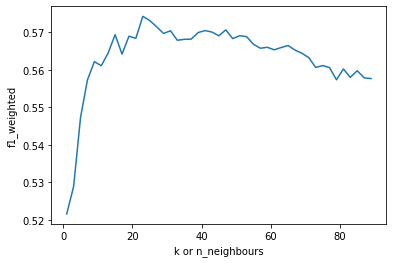

In [90]:
from sklearn.model_selection import cross_validate

k = np.linspace(1, 89, 45).astype(int)

all_vals = []
all_trains = []
for ki in k:
    m = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=ki))
    scores = cross_validate(m, X_train, y_train,
                            cv=LeaveOneGroupOut(), groups=wells,
                            scoring=['f1_weighted'], return_train_score=True, n_jobs=6)
    all_vals.append(np.mean(scores['test_f1_weighted']))
    all_trains.append(np.mean(scores['train_f1_weighted']))
    
plt.plot(k, np.array(all_vals))
plt.xlabel('k or n_neighbours')
plt.ylabel('f1_weighted')

What value of `k` gives us the best result?

### Exercise

- Figure out `k_best`, the value of `k` corresponding to the best score in `vals`. <b><span title="You will find np.argmax() useful. It gives the position of the maximum value in an array. Try it on array([2,4,6,10,6,4,2]).">Hover for hint.</span></b>
- Create a new `KNeighborsClassifier` classifier where you specify the optimal number of neighbours.
- Write a new classification report for the new classifier.

In [91]:
# YOUR CODE HERE
k_best = 


SyntaxError: invalid syntax (2794205698.py, line 2)

In [92]:
k_best = k[np.argmax(all_vals)]

print(f"k_best = {k_best}\n")

m = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k_best))
y_pred = cross_val_predict(m, X_train, y_train, cv=LeaveOneGroupOut(), groups=wells)
print(classification_report(y_train, y_pred, digits=3))

k_best = 23

              precision    recall  f1-score   support

    dolomite      0.364     0.041     0.073        98
   limestone      0.648     0.618     0.633       591
    mudstone      0.305     0.247     0.273       401
   sandstone      0.276     0.112     0.159       259
   siltstone      0.707     0.909     0.796      1346
  wackestone      0.431     0.394     0.412       462

    accuracy                          0.603      3157
   macro avg      0.455     0.387     0.391      3157
weighted avg      0.559     0.603     0.568      3157



Once you have something, this should work:

Text(0, 0.5, 'f1_weighted')

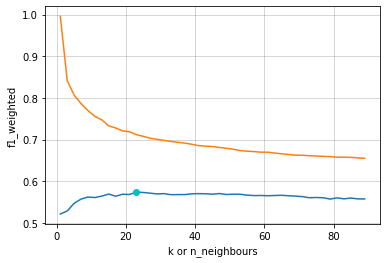

In [93]:
plt.plot(k, np.array(all_vals))
plt.plot(k, np.array(all_trains))
plt.plot(k_best, max(all_vals), 'co')  # <-- The max val score.
plt.grid(c='k', alpha=0.2)
plt.xlabel('k or n_neighbours')
plt.ylabel('f1_weighted')

This is the famous **bias-variance tradeoff** diagram, but it's usually drawn like this:

Text(0, 0.5, 'weighted F1 (Error increasing upwards)')

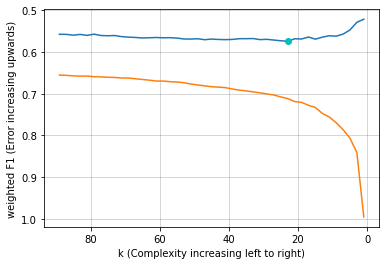

In [94]:
plt.plot(k, np.array(all_vals))
plt.plot(k, np.array(all_trains))
plt.plot(k_best, max(all_vals), 'co')
plt.grid(c='k', alpha=0.2)

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('k (Complexity increasing left to right)')
plt.ylabel('weighted F1 (Error increasing upwards)')

----

## Support vector machine

The support vector machine is one of the classic linear classifiers. A linear SVM is a **parametric** model, meaning that it learns a relatively small number of model parameters during training. [See this link for more on this jargon.](https://sebastianraschka.com/faq/docs/parametric_vs_nonparametric.html)

SVMs &mdash; linear and kernel-based &mdash; do well in high-dimensional data, but not sparse data. They also need all the features to be at the same scale, so they work well for things like pixel intensities.

### Exercise

Implement a support vector classifier and checks its effectiveness on the validation data, e.g. by printing the classification report.

In [95]:
from sklearn.svm import SVC

# YOUR CODE HERE


In [96]:
from sklearn.svm import SVC

m = make_pipeline(StandardScaler(), SVC())
scores = cross_val_score(m, X_train, y_train, cv=LeaveOneGroupOut(), groups=wells)
scores

array([0.618, 0.45 , 0.711, 0.661, 0.677, 0.629, 0.688])

In [97]:
y_pred = cross_val_predict(m, X_train, y_train, cv=LeaveOneGroupOut(), groups=wells)
print(classification_report(y_train, y_pred, digits=3))

              precision    recall  f1-score   support

    dolomite      0.385     0.153     0.219        98
   limestone      0.662     0.655     0.658       591
    mudstone      0.406     0.182     0.251       401
   sandstone      0.114     0.015     0.027       259
   siltstone      0.704     0.937     0.804      1346
  wackestone      0.480     0.548     0.512       462

    accuracy                          0.631      3157
   macro avg      0.458     0.415     0.412      3157
weighted avg      0.567     0.631     0.582      3157



Many, but not all, models provide probabilistic classifications. When you call `predict()`, you're getting the `argmax` of this array†.

---

† Sort of... the probabilities do not necessarily exactly match the predictions made by the SVM, which depend on the distance to the decision hypersurface in a high-dimenional space. The process that estimates probability, Platt scaling, is not totally predictable; [see the documentation.](https://scikit-learn.org/stable/modules/svm.html#scores-and-probabilities)

In [98]:
m = make_pipeline(StandardScaler(), SVC(probability=True))

y_prob = cross_val_predict(m, X_train, y_train,
                           cv=LeaveOneGroupOut(), groups=wells,
                           method='predict_proba')

np.set_printoptions(precision=3)  # Easier to read one per line.
y_prob[:5]

array([[0.012, 0.66 , 0.081, 0.002, 0.064, 0.181],
       [0.008, 0.192, 0.119, 0.015, 0.568, 0.097],
       [0.002, 0.017, 0.064, 0.057, 0.837, 0.023],
       [0.003, 0.016, 0.072, 0.055, 0.83 , 0.023],
       [0.001, 0.005, 0.053, 0.081, 0.847, 0.013]])

Note that by default, the SVM will use regularization (unlike the usual alpha, the C hyperparameter is **inversely** proportional to the amount of regularization, so use low C for smoother models), and kernel transformations (fitting non-linearly separable data).

### EXERCISE

Let's see how the training and validation scores vary with C. Can you loop over values of C (it's an exponential property, so try using `np.logspace()` to make an array of values to test) &mdash; collect the values and make a plot, as before.

In [99]:
# YOUR CODE HERE



In [100]:
from sklearn.svm import SVC

C = np.logspace(-3, 3, 13)

all_vals = []
all_trains = []
for Ci in C:
    m = make_pipeline(StandardScaler(), SVC(C=Ci))
    scores = cross_validate(m, X_train, y_train,
                            cv=LeaveOneGroupOut(), groups=wells,
                            scoring=['f1_weighted'], return_train_score=True, n_jobs=6)
    all_vals.append(np.mean(scores['test_f1_weighted']))
    all_trains.append(np.mean(scores['train_f1_weighted']))

Text(0, 0.5, 'Score (error increasing upwards)')

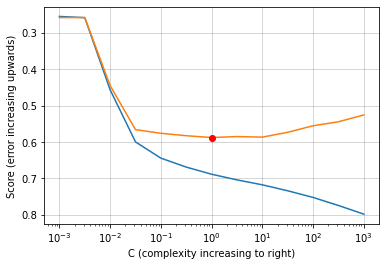

In [101]:
plt.plot(C, np.array(all_trains))
plt.plot(C, np.array(all_vals))
plt.plot(C[np.argmax(all_vals)], max(all_vals), 'ro')  # <-- The max val score.
plt.grid(c='k', alpha=0.2)
plt.xscale('log')
plt.gca().invert_yaxis()
plt.xlabel('C (complexity increasing to right)')
plt.ylabel('Score (error increasing upwards)')

Looks like the range 1 to 10 is where we want to look. (1 also happens to be the default.)

## ROC-AUC as a model selection tool

The **Area Under the Curve** (AUC) of the [**Receiver Operating Characteristic** (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is another way to compare models (or versions of the model with different hyperparameter settings).

[Here's a great video about the AUC-ROC method.](https://www.youtube.com/watch?v=4jRBRDbJemM)

We won't go into the ROC-AUC here; look for [the binary classification notebook](Binary_classification.ipynb).

----
## Decision trees and ensembles of trees

Decision trees are another non-parametric model type (like KNN). You can try one like this:

```python
from sklearn.tree import DecisionTreeClassifier

model = make_pipeline(StandardScaler(), DecisionTreeClassifier(max_depth=4))
y_pred = cross_val_predict(model, X_train, y_train, cv=LeaveOneGroupOut(), groups=wells)
print(classification_report(y_train, y_pred, digits=3))
```

They have the advantage of being more explainable than a lot of other model types. They tend to do quite well with little tuning, however they are prone to overfitting.

**Ensembles** of trees try to fix the overfitting problem. One example of an ensemble is a **random forest**.

## Random forests

Decision trees are prone to overtraining. An ensemble of decision trees can help avoid this... and makes for a highly effective classifier.

### Exercise

Implement a Random Forest.

In [ ]:
# YOUR CODE HERE



In [102]:
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(StandardScaler(), RandomForestClassifier())
y_pred = cross_val_predict(model, X_train, y_train, cv=LeaveOneGroupOut(), groups=wells)
print(classification_report(y_train, y_pred, digits=3))

              precision    recall  f1-score   support

    dolomite      0.339     0.194     0.247        98
   limestone      0.594     0.633     0.613       591
    mudstone      0.357     0.239     0.287       401
   sandstone      0.282     0.135     0.183       259
   siltstone      0.737     0.863     0.795      1346
  wackestone      0.426     0.463     0.444       462

    accuracy                          0.602      3157
   macro avg      0.456     0.421     0.428      3157
weighted avg      0.567     0.602     0.578      3157



A nice feature of tree-based models is being able to easily get a **feature importance**, for example:

In [103]:
model.fit(X_train, y_train)  # Must fit it first.
model.named_steps['randomforestclassifier'].feature_importances_

array([0.29 , 0.194, 0.271, 0.245])

---

## Choosing the right estimator

Often the hardest parts of solving a machine learning problem can be finding the right estimator for the job.

This is a good place to start ([here](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) is a clickable version):

<img src="https://scikit-learn.org/stable/_static/ml_map.png"></img>

---

Different estimators are better suited for different types of data and different problems. For a classifier comparison (below) check the source code [here](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png"></img>

### [Check out this paper with a comparison of many classifiers](https://arxiv.org/abs/1708.05070)

### Exercise

- Can you beat our current high score by twiddling hyperparameters on one of these models?
- Or, try other methods available in the scikit-learn library. See the list [here](http://scikit-learn.org/stable/supervised_learning.html). For example, get a sneak peek at neural nets with the MLP.

In [ ]:
# YOUR CODE HERE


----

## Hyperparameter tuning

Many of the models can be improved (or worsened) by changing the parameters that internally make the method work. It's always a good idea to check the documentation of each model (e.g. `RandomForestClassifier` [docs](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). This process is usually called _hyperparameter tuning_.

Scikit-learn offers a simple way to test different parameters for each model through a function called `GridSearchCV`.

As with other cross validation tools in `sklearn`, the default behviour is to split the training data randomly into _k_ 'folds'. But we'll define a 'LOGO' splitter as before.

In [104]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

model = Pipeline(steps=[('scaler', StandardScaler()),
                        ('classifier', RandomForestClassifier()),
                       ])

param_grid = {'classifier__max_depth': np.arange(4, 12),
              'classifier__min_samples_leaf': np.arange(2, 9),
              'classifier__random_state': [42], 
             }
             
clf = GridSearchCV(model, param_grid,
                   scoring='f1_weighted',
                   cv=LeaveOneGroupOut(),
                   n_jobs=6, verbose=1,
                  )

clf.fit(X_train, y_train, groups=wells)

Fitting 7 folds for each of 56 candidates, totalling 392 fits


GridSearchCV(cv=LeaveOneGroupOut(), error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('classifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                      

In [56]:
clf.cv_results_

{'mean_fit_time': array([0.239, 0.217, 0.215, 0.216, 0.214, 0.225, 0.217, 0.241, 0.243,
        0.245, 0.285, 0.28 , 0.247, 0.246, 0.293, 0.316, 0.293, 0.294,
        0.337, 0.35 , 0.377, 0.35 , 0.357, 0.355, 0.323, 0.309, 0.308,
        0.309, 0.341, 0.465, 0.729, 0.426, 0.412, 0.437, 0.468, 0.571,
        0.443, 0.423, 0.42 , 0.416, 0.406, 0.409, 0.461, 0.451, 0.443,
        0.431, 0.433, 0.426, 0.447, 0.475, 0.501, 0.492, 0.486, 0.448,
        0.433, 0.424]),
 'std_fit_time': array([0.032, 0.005, 0.003, 0.005, 0.001, 0.008, 0.004, 0.002, 0.006,
        0.007, 0.027, 0.04 , 0.004, 0.006, 0.009, 0.012, 0.017, 0.018,
        0.048, 0.049, 0.033, 0.023, 0.027, 0.015, 0.014, 0.004, 0.005,
        0.005, 0.009, 0.136, 0.132, 0.013, 0.007, 0.034, 0.045, 0.062,
        0.018, 0.007, 0.006, 0.004, 0.004, 0.005, 0.015, 0.017, 0.005,
        0.005, 0.012, 0.005, 0.013, 0.007, 0.027, 0.021, 0.009, 0.014,
        0.007, 0.016]),
 'mean_score_time': array([0.011, 0.011, 0.011, 0.012, 0.011, 0.012

Let's see how we do on each well as we omit it from the training in turn:

In [105]:
for i, well in enumerate(np.unique(wells)):
    scores = clf.cv_results_[f'split{i}_test_score']
    print(f"{well:>16s} ... {np.mean(scores):.4f}")

 CHURCHMAN BIBLE ... 0.5663
  CROSS H CATTLE ... 0.4498
        LUKE G U ... 0.6704
           NEWBY ... 0.5513
           NOLAN ... 0.6747
         SHANKLE ... 0.5597
       SHRIMPLIN ... 0.6729


`clf` can now tell us the best parameters to use with our `RandomForestClassifier`

In [106]:
clf.best_params_

{'classifier__max_depth': 6,
 'classifier__min_samples_leaf': 6,
 'classifier__random_state': 42}

In [107]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=6, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=6, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [108]:
clf.best_score_

0.5989967070626793

This is close to the SVM performance.

## Test the model

Now might be a good time to check our **test** set — the one we reserved at the start. How might our model do on this dataset?

In [109]:
from sklearn.metrics import f1_score

f1_score(y_test, clf.predict(X_test), average='weighted')

0.4838520098121064

We get a worse result than what we were getting in validation. Why?

- We overfit to the training data.
- The test wells are not like the training wells.
- There's a problem with the data.

## Training the final model

Now that we have selected the model we want to use, we should retrain it on all of the data.

NB We could omit the scaling step for a random forest. But it doesn't do any harm...

In [110]:
model = clf.best_estimator_.fit(X, y)

We don't have anything to test this on, but we expect it to achieve similar performance to that against the test set.

## Model persistence

Often, we'd like to save the trained model, to go and apply it in some other application, or to share with someone else. The easiest way to save most models is as a Python 'pickle' object:

In [111]:
import joblib

joblib.dump(model, 'facies_pipeline.pkl')

['facies_pipeline.pkl']

## Model application

How do you load and use a saved model?

In [112]:
model = joblib.load('facies_pipeline.pkl')

In [113]:
model.named_steps

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'classifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=6, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=6, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False)}

Now you can load some data:

    df = pd.read_csv('..some_new_data_you_have_collected.csv')
  
Then extract the relevant features and cast it as a 2D array:

    X_new = df[['GR','RHOB','PE','ILD_log10']].values

Now pass the matrix `X_new` into the classifier's predict method:

    y_pred = model.predict(X_new)

And you're done!

<hr />

<p style="color:gray">©2021&ndash;2022 Agile Geoscience. Licensed CC-BY.</p>